# Causal Bayesian Network tutorial

The following notebook will cover how to specify the graphical structure and causal/probabilistic relationships of CBNs in PyCID, and how to answer causal and probabilistic queries.

To open this notebook in Google Colab, click the following link:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/causalincentives/pycid/blob/master/notebooks/CBN_Tutorial.ipynb)

In [2]:
#importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install pycid  # or  !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid for the latest development version
    import pycid
    
import numpy as np


     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 324 kB 18.9 MB/s 


## 1. Graphical Structure

The structure of a CBN is specified by a list of edges. This implicitly specifies the nodes as well.

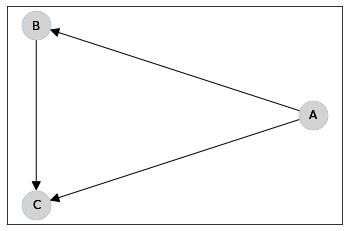

In [3]:
cbn = pycid.CausalBayesianNetwork([
        ('A', 'B'),  #specifies the MAICD's nodes and edges.
        ('A', 'C'),
        ('B', 'C')
        ],
)

cbn.draw()

## 2. Distributions

PyCID is designed to make it easy to quickly specify causal and probabilistic relationships between nodes in a DAG.

Distributions are represented with dictionaries `{outcome: P(outcome)}` that have possible outcomes as keys, and the probability of the outcome as value. For example, a Bernoulli(0.6) distribution can be represented as `{0: 0.4, 1: 0.6}`.

We can add such a distribution to the node A in the network we just specified.

In [4]:
cbn.model['A'] = {0: 0.4, 1: 0.6}  
# alternatively: cbn.model['A'] = pycid.bernoulli(0.6)
print("PyCID representation")
print(cbn.model['A'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('A'))

PyCID representation
{0: 0.4, 1: 0.6}

Underlying pgmpy representation
+------+-----+
| A(0) | 0.4 |
+------+-----+
| A(1) | 0.6 |
+------+-----+


## 3. Conditional distributions

Conditional distributions can be specified with functions that return distribution-dictionaries, and whose arguments match the names of the parent variables. For example, we can specify that B is a Bernoulli distribution whose parameter depends on A, say as B ~ Bernoulli((1+A)/3), via

In [5]:
cbn.model['B'] = lambda A: pycid.bernoulli((1 + A)/3)
print("PyCID representation")
print(cbn.model['B'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('B'))

PyCID representation
<function <lambda> at 0x7f5759d510e0>

Underlying pgmpy representation
+------+--------------------+---------------------+
| A    | A(0)               | A(1)                |
+------+--------------------+---------------------+
| B(0) | 0.6666666666666667 | 0.33333333333333337 |
+------+--------------------+---------------------+
| B(1) | 0.3333333333333333 | 0.6666666666666666  |
+------+--------------------+---------------------+


Arbitrary stochastic relationsbips can be specified with inline if-else statements. For example, we can specify the distribution for C based on the different outcomes for A and B as follows

In [7]:
cbn.model['C'] = lambda A, B: (pycid.bernoulli(0.2) if A==0 and B==0 else
                               pycid.bernoulli(0.3) if A==0 and B==1 else
                               pycid.bernoulli(0.4) if A==1 and B==0 else
                               pycid.bernoulli(0.5))

print("PyCID representation")
print(cbn.model['C'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('C'))

PyCID representation
<function <lambda> at 0x7f575987ed40>

Underlying pgmpy representation
+------+------+------+------+------+
| A    | A(0) | A(0) | A(1) | A(1) |
+------+------+------+------+------+
| B    | B(0) | B(1) | B(0) | B(1) |
+------+------+------+------+------+
| C(0) | 0.8  | 0.7  | 0.6  | 0.5  |
+------+------+------+------+------+
| C(1) | 0.2  | 0.3  | 0.4  | 0.5  |
+------+------+------+------+------+


## 4. Conditional distributions -- advanced

Here we cover a few more advanced tricks for specifying probabilistic relationships in PyCID.

### 4.1 Deterministic functions

First, if a function is returning a single value rather than a dictionary, then it is interpreted as a deterministic function, i.e. a degenerate probability distribution. This is useful when specifying structural causal models.

For example, we can specify that B is the inverse of A as follows:

In [8]:
cbn.model['B'] = lambda A: 1-A
print("PyCID representation")
print(cbn.model['B'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('B'))

PyCID representation
<function <lambda> at 0x7f586e634dd0>

Underlying pgmpy representation
+------+------+------+
| A    | A(0) | A(1) |
+------+------+------+
| B(0) | 0.0  | 1.0  |
+------+------+------+
| B(1) | 1.0  | 0.0  |
+------+------+------+


### 4.2 Incomplete distributions

If a distribution dictionary contains `None` values, then the remaining probability mass will be spread equally over those keys. For example, we can specify that A has the distribution `{0: 0.6, 1: 0.2, 2: 0.2}` with the dictionary `{0: 0.6, 1: None, 2: None}`:

In [9]:
cbn.model['A'] = {0: 0.6, 1: None, 2: None}  
# alternatively: cbn.model['A'] = pycid.bernoulli(0.6)
print("PyCID representation")
print(cbn.model['A'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('A'))

PyCID representation
{0: 0.6, 1: None, 2: None}

Underlying pgmpy representation
+------+-----+
| A(0) | 0.6 |
+------+-----+
| A(1) | 0.2 |
+------+-----+
| A(2) | 0.2 |
+------+-----+


This is especially timesaving when specifying a complicated distribution involving several if-clauses:

In [10]:
cbn.model['C'] = lambda A, B: {0: (0.2 if A==0 and B==0 else
                                   0.3 if A==0 and B==1 else
                                   0.4), 
                               1: None}  # This completes to 1-P(0)

print("PyCID representation")
print(cbn.model['C'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('C'))

PyCID representation
<function <lambda> at 0x7f5759859b90>

Underlying pgmpy representation
+------+-------+------+------+-------+------+------+-------+------+------+
| A    | A(0)  | A(0) | A(0) | A(1)  | A(1) | A(1) | A(2)  | A(2) | A(2) |
+------+-------+------+------+-------+------+------+-------+------+------+
| B    | B(-1) | B(0) | B(1) | B(-1) | B(0) | B(1) | B(-1) | B(0) | B(1) |
+------+-------+------+------+-------+------+------+-------+------+------+
| C(0) | 0.4   | 0.2  | 0.3  | 0.4   | 0.4  | 0.4  | 0.4   | 0.4  | 0.4  |
+------+-------+------+------+-------+------+------+-------+------+------+
| C(1) | 0.6   | 0.8  | 0.7  | 0.6   | 0.6  | 0.6  | 0.6   | 0.6  | 0.6  |
+------+-------+------+------+-------+------+------+-------+------+------+


### 4.3 Incomplete distributions in functions

Sometimes the keys of the dictionary will depend on the arguments to the function. For example, consider the function `lambda A: {A: 0.9}` that makes B a "noisy copy" of A. For any given value of A, it will always output an incomplete dictionary with only a single key, and whose values only sum to 0.9. Even though there are no `None`-keys present, PyCID can still effectively infer the remaining `None`-keys by looking at the keys over different values of A.

In [11]:
cbn.model['B'] = lambda A: {A: 0.9}
print("PyCID representation")
print(cbn.model['B'])
print("\nUnderlying pgmpy representation")
print(cbn.get_cpds('B'))

PyCID representation
<function <lambda> at 0x7f57598594d0>

Underlying pgmpy representation
+------+---------------------+---------------------+---------------------+
| A    | A(0)                | A(1)                | A(2)                |
+------+---------------------+---------------------+---------------------+
| B(0) | 0.9                 | 0.04999999999999999 | 0.04999999999999999 |
+------+---------------------+---------------------+---------------------+
| B(1) | 0.04999999999999999 | 0.9                 | 0.04999999999999999 |
+------+---------------------+---------------------+---------------------+
| B(2) | 0.04999999999999999 | 0.04999999999999999 | 0.9                 |
+------+---------------------+---------------------+---------------------+


## 5 Queries and expectations

Usually, the reason we go through the effort of writing down a model in PyCID is to be able to automatically answer various probabilistic queries about it.

### 5.1 Probabilistic queries

For example, what is the distribution of C given that B=1?

In [15]:
print(cbn.query(['C'], context = {'B': 1}))

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.3864 |
+------+----------+
| C(1) |   0.6136 |
+------+----------+


### 5.2 Expectations

It is also possible to find out the joint distribution of A and C given B=1:

In [17]:
print(cbn.query(['A', 'C'], context = {'B': 1}))

+------+------+------------+
| C    | A    |   phi(C,A) |
+======+======+============+
| C(0) | A(0) |     0.0409 |
+------+------+------------+
| C(0) | A(1) |     0.3273 |
+------+------+------------+
| C(0) | A(2) |     0.0182 |
+------+------+------------+
| C(1) | A(0) |     0.0955 |
+------+------+------------+
| C(1) | A(1) |     0.4909 |
+------+------+------------+
| C(1) | A(2) |     0.0273 |
+------+------+------------+


Similarly, we can also query the expected value of C in the given context

In [16]:
print(cbn.expected_value(['C'], context = {'B': 1}))

[0.6136363636363636]


### 5.3 Causal queries

Causal interventions work analogously

In [21]:
print("distribution", cbn.query(['C'], context = {'A': 1}, intervention = {'B': 0}))
print("expected value", cbn.expected_value(['C'], context = {'A': 1}, intervention = {'B': 0}))

distribution +------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.4000 |
+------+----------+
| C(1) |   0.6000 |
+------+----------+
expected value [0.6]
